# Time Series Prediction

**Objectives**
 1. Build a linear, DNN and CNN model in keras to predict stock market behavior.
 2. Build a simple RNN model and a multi-layer RNN model in keras.
 3. Combine RNN and CNN architecture to create a keras model to predict stock market behavior.
 
In this lab we will build a custom Keras model to predict stock market behavior using the stock market dataset we created in the previous labs. We'll start with a linear, DNN and CNN model 

Since the features of our model are sequential in nature, we'll next look at how to build various RNN models in keras. We'll start with a simple RNN model and then see how to create a multi-layer RNN in keras. We'll also see how to combine features of 1-dimensional CNNs with a typical RNN architecture. 

We will be exploring a lot of different model types in this notebook. To keep track of your results, record the accuracy on the validation set in the table here. In machine learning there are rarely any "one-size-fits-all" so feel free to test out different hyperparameters (e.g. train steps, regularization, learning rates, optimizers, batch size) for each of the models. Keep track of your model performance in the chart below.

|  Model   | Validation Accuracy  |
|----------|:---------------:|
| Baseline |    0.295         |
| Linear   |    --        |
| DNN      |    --         |
| 1-d CNN  |    --         |
| simple RNN  |    --         |
| multi-layer RNN  |    --         |
| RNN using CNN features  |    --         |
| CNN using RNN features  |    --         |

## Load necessary libraries and set up environment variables

In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from google.cloud import bigquery
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import (
    GRU,
    LSTM,
    RNN,
    Bidirectional,
    Conv1D,
    Dense,
    MaxPool1D,
    Reshape,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# To plot pretty figures
%matplotlib inline
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

# For reproducible results.
from numpy.random import seed

seed(1)
tf.random.set_seed(2)

In [2]:
PROJECT = !(gcloud config get-value core/project)
PROJECT = PROJECT[0]
%env PROJECT = {PROJECT}
%env BUCKET = {PROJECT}
%env REGION = "us-central1"

env: PROJECT=qwiklabs-asl-03-5d5c0ba6f6d6
env: BUCKET=qwiklabs-asl-03-5d5c0ba6f6d6
env: REGION="us-central1"


## Explore time series data

We'll start by pulling a small sample of the time series data from Big Query and write some helper functions to clean up the data for modeling. We'll use the data from the `percent_change_sp500` table in BigQuery. The `close_values_prior_260` column contains the close values for any given stock for the previous 260 days. 

In [ ]:
%%time
bq = bigquery.Client(project=PROJECT)

bq_query = """
#standardSQL
SELECT
  symbol,
  Date,
  direction,
  close_values_prior_260
FROM
  `stock_market.eps_percent_change_sp500`
LIMIT
  100
"""

df_stock_raw = bq.query(bq_query).to_dataframe()

In [ ]:
df_stock_raw.head()

The function `clean_data` below does three things:
 1. First, we'll remove any inf or NA values
 2. Next, we parse the `Date` field to read it as a string.
 3. Lastly, we convert the label `direction` into a numeric quantity, mapping 'DOWN' to 0, 'STAY' to 1 and 'UP' to 2. 

In [ ]:
def clean_data(input_df):
    """Cleans data to prepare for training.

    Args:
        input_df: Pandas dataframe.
    Returns:
        Pandas dataframe.
    """
    df = input_df.copy()

    # TF doesn't accept datetimes in DataFrame.
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df["Date"] = df["Date"].dt.strftime("%Y-%m-%d")

    # TF requires numeric label.
    df["direction_numeric"] = df["direction"].apply(
        lambda x: {"DOWN": 0, "STAY": 1, "UP": 2}[x]
    )
    return df

In [ ]:
df_stock = clean_data(df_stock_raw)

In [ ]:
df_stock.head()

## Read data and preprocessing

Before we begin modeling, we'll preprocess our features by scaling to the z-score. This will ensure that the range of the feature values being fed to the model are comparable and should help with convergence during gradient descent.

In [3]:
STOCK_HISTORY_COLUMN = "close_values_prior_260"
COL_NAMES = ["day_" + str(day) for day in range(0, 260)]
LABEL = "direction_numeric"

In [ ]:
def _scale_features(df):
    """z-scale feature columns of Pandas dataframe.

    Args:
        features: Pandas dataframe.
    Returns:
        Pandas dataframe with each column standardized according to the
        values in that column.
    """
    avg = df.mean()
    std = df.std()
    return (df - avg) / std


def create_features(df, label_name):
    """Create modeling features and label from Pandas dataframe.

    Args:
        df: Pandas dataframe.
        label_name: str, the column name of the label.
    Returns:
        Pandas dataframe
    """
    # Expand 1 column containing a list of close prices to 260 columns.
    time_series_features = df[STOCK_HISTORY_COLUMN].apply(pd.Series)

    # Rename columns.
    time_series_features.columns = COL_NAMES
    time_series_features = _scale_features(time_series_features)

    # Concat time series features with static features and label.
    label_column = df[LABEL]

    return pd.concat([time_series_features, label_column], axis=1)

In [ ]:
df_features = create_features(df_stock, LABEL)

In [ ]:
df_features.head()

Let's plot a few examples and see that the preprocessing steps were implemented correctly.

In [ ]:
ix_to_plot = [0, 1, 9, 5]
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
for ix in ix_to_plot:
    label = df_features["direction_numeric"].iloc[ix]
    example = df_features[COL_NAMES].iloc[ix]
    ax = example.plot(label=label, ax=ax)
    ax.set_ylabel("scaled price")
    ax.set_xlabel("prior days")
    ax.legend()

### Make train-eval-test split

Next, we'll make repeatable splits for our train/validation/test datasets and save these datasets to local csv files. The query below will take a subsample of the entire dataset and then create a 70-15-15 split for the train/validation/test sets. 

In [ ]:
def _create_split(phase):
    """Create string to produce train/valid/test splits for a SQL query.

    Args:
        phase: str, either TRAIN, VALID, or TEST.
    Returns:
        String.
    """
    floor, ceiling = "2002-11-01", "2010-07-01"
    if phase == "VALID":
        floor, ceiling = "2010-07-01", "2011-09-01"
    elif phase == "TEST":
        floor, ceiling = "2011-09-01", "2012-11-30"
    return """
    WHERE Date >= '{}'
    AND Date < '{}'
    """.format(
        floor, ceiling
    )


def create_query(phase):
    """Create SQL query to create train/valid/test splits on subsample.

    Args:
        phase: str, either TRAIN, VALID, or TEST.
        sample_size: str, amount of data to take for subsample.
    Returns:
        String.
    """
    basequery = """
    #standardSQL
    SELECT
      symbol,
      Date,
      direction,
      close_values_prior_260
    FROM
      `stock_market.eps_percent_change_sp500`
    """

    return basequery + _create_split(phase)

In [ ]:
bq = bigquery.Client(project=PROJECT)

for phase in ["TRAIN", "VALID", "TEST"]:
    # 1. Create query string
    query_string = create_query(phase)
    # 2. Load results into DataFrame
    df = bq.query(query_string).to_dataframe()

    # 3. Clean, preprocess dataframe
    df = clean_data(df)
    df = create_features(df, label_name="direction_numeric")

    # 3. Write DataFrame to CSV
    if not os.path.exists("../data"):
        os.mkdir("../data")
    df.to_csv(
        f"../data/stock-{phase.lower()}.csv",
        index_label=False,
        index=False,
    )
    print(
        "Wrote {} lines to {}".format(
            len(df), f"../data/stock-{phase.lower()}.csv"
        )
    )

In [4]:
ls -la ../data

total 81436
drwxr-xr-x 2 jupyter jupyter     4096 Jul 11 18:42 ./
drwxr-xr-x 7 jupyter jupyter     4096 Jul 11 18:42 ../
-rw-r--r-- 1 jupyter jupyter 12796169 Jul 11 18:42 stock-test.csv
-rw-r--r-- 1 jupyter jupyter 58125287 Jul 11 18:42 stock-train.csv
-rw-r--r-- 1 jupyter jupyter 12453929 Jul 11 18:42 stock-valid.csv


## Modeling

For experimentation purposes, we'll train various models using data we can fit in memory using the `.csv` files we created above. 

In [5]:
N_TIME_STEPS = 260
N_LABELS = 3

Xtrain = pd.read_csv("../data/stock-train.csv")
Xvalid = pd.read_csv("../data/stock-valid.csv")

ytrain = Xtrain.pop(LABEL)
yvalid = Xvalid.pop(LABEL)

ytrain_categorical = to_categorical(ytrain.values)
yvalid_categorical = to_categorical(yvalid.values)

To monitor training progress and compare evaluation metrics for different models, we'll use the function below to plot metrics captured from the training job such as training and validation loss or accuracy.

In [8]:
Xtrain.head()

,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,day_250,day_251,day_252,day_253,day_254,day_255,day_256,day_257,day_258,day_259
0,-0.144946,-0.135877,-0.146586,-0.149944,-0.151658,-0.149648,-0.150216,-0.151742,-0.135856,-0.127655,...,-0.175549,-0.175757,-0.164736,-0.172003,-0.183098,-0.192609,-0.185822,-0.213345,-0.216334,-0.217794
1,-0.458200,-0.455591,-0.449417,-0.435703,-0.440224,-0.451866,-0.436883,-0.506776,-0.502588,-0.502273,...,-0.294629,-0.291526,-0.280120,-0.279749,-0.277877,-0.275013,-0.273712,-0.272388,-0.272866,-0.275396
2,-0.499667,-0.462806,-0.493355,-0.533280,-0.523828,-0.526971,-0.543039,-0.578633,-0.543261,-0.551535,...,-0.454946,-0.447208,-0.449216,-0.449001,-0.425582,-0.423695,-0.406763,-0.405733,-0.396572,-0.396778
3,-0.391268,-0.341053,-0.369879,-0.386690,-0.375050,-0.316947,-0.345732,-0.349629,-0.341235,-0.357845,...,-0.647680,-0.645668,-0.649038,-0.648785,-0.642600,-0.641747,-0.644087,-0.642570,-0.634895,-0.637778
4,-0.144946,-0.135877,-0.146586,-0.149944,-0.151658,-0.149648,-0.150216,-0.151742,-0.135856,-0.127655,...,-0.175549,-0.175757,-0.164736,-0.172003,-0.183098,-0.192609,-0.185822,-0.213345,-0.216334,-0.217794


In [10]:
ytrain

0        2
1        2
2        2
3        2
4        2
        ..
11159    1
11160    1
11161    1
11162    1
11163    1
Name: direction_numeric, Length: 11164, dtype: int64

In [11]:
def plot_curves(train_data, val_data, label="Accuracy"):
    """Plot training and validation metrics on single axis.

    Args:
        train_data: list, metrics obtrained from training data.
        val_data: list, metrics obtained from validation data.
        label: str, title and label for plot.
    Returns:
        Matplotlib plot.
    """
    plt.plot(
        np.arange(len(train_data)) + 0.5,
        train_data,
        "b.-",
        label="Training " + label,
    )
    plt.plot(
        np.arange(len(val_data)) + 1,
        val_data,
        "r.-",
        label="Validation " + label,
    )
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel(label)
    plt.grid(True)

### Baseline

Before we begin modeling in keras, let's create a benchmark using a simple heuristic. Let's see what kind of accuracy we would get on the validation set if we predict the majority class of the training set. 

In [12]:
sum(yvalid == ytrain.value_counts().idxmax()) / yvalid.shape[0]

0.29490392648287383

Ok. So just naively guessing the most common outcome `UP` will give about 29.5% accuracy on the validation set. 

### Linear model

We'll start with a simple linear model, mapping our sequential input to a single fully dense layer. 

**Lab Task #1a:** In the cell below, create a linear model using the [keras sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) which maps the sequential input to a single dense fully connected layer.

In [18]:
# TODO 1a
model = Sequential()

model.add(
    # TODO: Your code goes here.
    Dense(
        units=N_LABELS,
        activation="softmax",
        kernel_regularizer=tf.keras.regularizers.l1(l=0.1),
    )
)

model.compile(
    # TODO: Your code goes here.
    optimizer=Adam(lr=0.01),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    # TODO: Your code goes here.
    x=Xtrain.values,
    y=ytrain_categorical,
    batch_size=Xtrain.shape[0],
    validation_data=(Xtrain.values, ytrain_categorical),
    epochs=30,
    verbose=0,
)

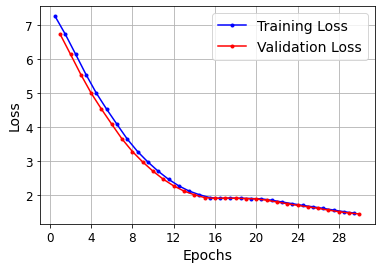

In [19]:
plot_curves(history.history["loss"], history.history["val_loss"], label="Loss")

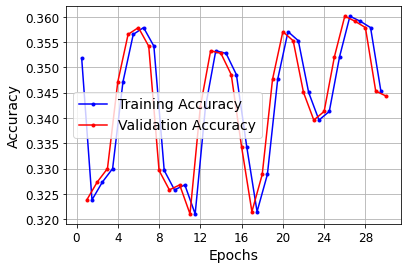

In [20]:
plot_curves(
    history.history["accuracy"],
    history.history["val_accuracy"],
    label="Accuracy",
)

The accuracy seems to level out pretty quickly. To report the accuracy, we'll average the accuracy on the validation set across the last few epochs of training.

In [21]:
np.mean(history.history["val_accuracy"][-5:])

0.3533321380615234

### Deep Neural Network

The linear model is an improvement on our naive benchmark. Perhaps we can do better with a more complicated model. Next, we'll create a deep neural network with keras. We'll experiment with a two layer DNN here but feel free to try a more complex model or add any other additional techniques to try an improve your performance. 

**Lab Task #1b:** In the cell below, create a deep neural network in keras to model `direction_numeric`. Experiment with different activation functions or add regularization to see how much you can improve performance. 

In [124]:
# TODO 1b
model = Sequential()

# TODO: Your code goes here.
dnn_hidden_units = [16, 64, 32, 8]
for idx, layer in enumerate(dnn_hidden_units):
    model.add(Dense(units=layer, activation="relu"))
    # if idx == 1:
    #     model.add(tf.keras.layers.Dropout(0.2))

model.add(
    Dense(
        units=N_LABELS,
        activation="softmax",
        kernel_regularizer=tf.keras.regularizers.l1(l=0.1),
    )
)

model.compile(
    optimizer=Adam(),  # learning_rate=0.01),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    x=Xtrain.values,
    y=ytrain_categorical,
    batch_size=Xtrain.shape[0],
    validation_data=(Xtrain.values, ytrain_categorical),
    epochs=30,
    verbose=0,
)

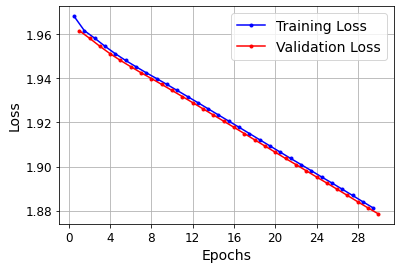

In [125]:
plot_curves(history.history["loss"], history.history["val_loss"], label="Loss")

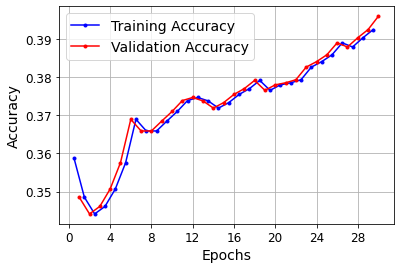

In [126]:
plot_curves(
    history.history["accuracy"],
    history.history["val_accuracy"],
    label="Accuracy",
)

In [127]:
np.mean(history.history["val_accuracy"][-5:])

0.39116803407669065

### Convolutional Neural Network

The DNN does slightly better. Let's see how a convolutional neural network performs. 

A 1-dimensional convolutional can be useful for extracting features from sequential data or deriving features from shorter, fixed-length segments of the data set. Check out the documentation for how to implement a [Conv1d in Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D). Max pooling is a downsampling strategy commonly used in conjunction with convolutional neural networks. Next, we'll build a CNN model in keras using the `Conv1D` to create convolution layers and `MaxPool1D` to perform max pooling before passing to a fully connected dense layer. 

**Lab Task #1b:** Create 1D Convolutional network in keras. You can experiment with different numbers of convolutional layers, filter sizes, kernals sizes and strides, pooling layers etc. After passing through the convolutional layers, flatten the result and pass through a deep neural network to complete the model. 

In [131]:
# TODO 1c
model = Sequential()

# Convolutional layer(s)
# TODO: Your code goes here.
model.add(Reshape(target_shape=[N_TIME_STEPS, 1]))
model.add(
    Conv1D(
        filters=5,
        kernel_size=5,
        strides=2,
        padding="valid",
        input_shape=[None, 1],
    )
)
model.add(MaxPool1D(pool_size=2, padding="valid", strides=None))


# Flatten the result and pass through DNN.
# TODO: Your code goes here.
model.add(tf.keras.layers.Flatten())
model.add(Dense(units=N_TIME_STEPS // 4, activation="relu"))

model.add(
    Dense(
        units=N_LABELS,
        activation="softmax",
        kernel_regularizer=tf.keras.regularizers.l1(l=0.01),
    )
)

# Compile your model and train
# TODO: Your code goes here.

model.compile(
    optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
)

history = model.fit(
    x=Xtrain.values,
    y=ytrain_categorical,
    batch_size=Xtrain.shape[0],
    validation_data=(Xvalid.values, yvalid_categorical),
    epochs=10,
    verbose=0,
)

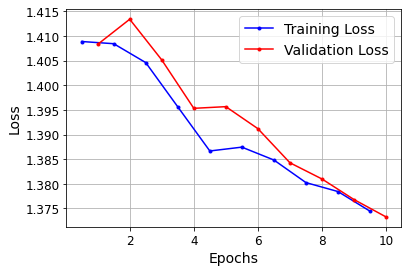

In [132]:
plot_curves(history.history["loss"], history.history["val_loss"], label="Loss")

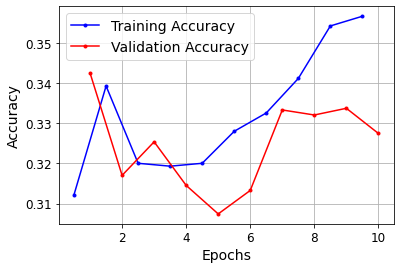

In [133]:
plot_curves(
    history.history["accuracy"],
    history.history["val_accuracy"],
    label="Accuracy",
)

In [134]:
np.mean(history.history["val_accuracy"][-5:])

0.3279866397380829

### Recurrent Neural Network

RNNs are particularly well-suited for learning sequential data. They retain state information from one iteration to the next by feeding the output from one cell as input for the next step. In the cell below, we'll build a RNN model in keras. The final state of the RNN is captured and then passed through a fully connected layer to produce a prediction.

**Lab Task #2a:** Create an RNN model in keras. You can try different types of RNN cells like [LSTMs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM), 
[GRUs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) or basic [RNN cell](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN). Experiment with different cell sizes, activation functions, regularization, etc.

In [ ]:
# TODO 2a
model = Sequential()

# Reshape inputs to pass through RNN layer.
# TODO: Your code goes here.

# Compile your model and train
# TODO: Your code goes here.

In [ ]:
plot_curves(history.history["loss"], history.history["val_loss"], label="Loss")

In [ ]:
plot_curves(
    history.history["accuracy"],
    history.history["val_accuracy"],
    label="Accuracy",
)

In [ ]:
np.mean(history.history["val_accuracy"][-5:])

### Multi-layer RNN

Next, we'll build multi-layer RNN. Just as multiple layers of a deep neural network allow for more complicated features to be learned during training, additional RNN layers can potentially learn complex features in sequential data. For a multi-layer RNN the output of the first RNN layer is fed as the input into the next RNN layer.

**Lab Task #2b:** Now that you've seen how to build a sinlge layer RNN, create an deep, multi-layer RNN model. Look into how you should set the `return_sequences` variable when instantiating the layers of your RNN.

In [ ]:
# TODO 2b

model = Sequential()

# Reshape inputs to pass through RNN layers.
# TODO: Your code goes here.

# Compile your model and train
# TODO: Your code goes here.

In [ ]:
plot_curves(history.history["loss"], history.history["val_loss"], label="Loss")

In [ ]:
plot_curves(
    history.history["accuracy"],
    history.history["val_accuracy"],
    label="Accuracy",
)

In [ ]:
np.mean(history.history["val_accuracy"][-5:])

### Combining CNN and RNN architecture

Finally, we'll look at some model architectures which combine aspects of both convolutional and recurrant networks. For example, we can use a 1-dimensional convolution layer to process our sequences and create features which are then passed to a RNN model before prediction. 

**Lab Task #3a:** Create a model that first passes through a 1D-Convolution then passes those sequential features through an sequential recurrent layer. You can experiment with different hyperparameters of the CNN and the RNN to see how much you can improve performance of your model. 

In [ ]:
# TODO 3a
model = Sequential()

# Reshape inputs for convolutional layer
# TODO: Your code goes here.

# Pass the convolutional features through RNN layer
# TODO: Your code goes here.

# Compile your model and train
# TODO: Your code goes here.

In [ ]:
plot_curves(history.history["loss"], history.history["val_loss"], label="Loss")

In [ ]:
plot_curves(
    history.history["accuracy"],
    history.history["val_accuracy"],
    label="Accuracy",
)

In [ ]:
np.mean(history.history["val_accuracy"][-5:])

We can also try building a hybrid model which uses a 1-dimensional CNN to create features from the outputs of an RNN.

**Lab Task #3b:** Lastly, create a model that passes through the recurrant layer of an RNN first before applying a 1D-Convolution. As before, the result of the CNN is then flattened and passed through the fully connected layer(s).

In [ ]:
# TODO 3b
model = Sequential()

# Reshape inputs and pass through RNN layer.
# TODO: Your code goes here.

# Apply 1d convolution to RNN outputs.
# TODO: Your code goes here.

# Flatten the convolution output and pass through DNN.
# TODO: Your code goes here.

# Compile your model and train
# TODO: Your code goes here.

In [ ]:
plot_curves(history.history["loss"], history.history["val_loss"], label="Loss")

In [ ]:
plot_curves(
    history.history["accuracy"],
    history.history["val_accuracy"],
    label="Accuracy",
)

In [ ]:
np.mean(history.history["val_accuracy"][-5:])

## Extra Credit

1. The `eps_percent_change_sp500` table also has static features for each example. Namely, the engineered features we created in the previous labs with aggregated information capturing the `MAX`, `MIN`, `AVG` and `STD` across the last 5 days, 20 days and 260 days (e.g. `close_MIN_prior_5_days`, `close_MIN_prior_20_days`, `close_MIN_prior_260_days`, etc.). Try building a model which incorporates these features in addition to the sequence features we used above. Does this improve performance?

2. The `eps_percent_change_sp500` table also contains a `surprise` feature which captures information about the earnings per share. Try building a model which uses the `surprise` feature in addition to the sequence features we used above. Does this improve performance?

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License